# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage


<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Classroom.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

### Student: Lucas Machado Moschen

In [ ]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
from IPython.core.display import HTML
def css_styling():
    styles = open("style/cs109.css", "r").read()
    return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [2]:
bikes_df = pd.read_csv('data/BSS_hour_raw.csv')
display(bikes_df.dtypes)
display(bikes_df.describe())

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


<HR>
Your answer here
<HR>

The dates are object (they can be datetime instead), but the other ones are ok. Workingday and holiday could be bool type, but int64 is not a proble. So yes, the data types seem to make sense. What does not make sense is the temp and atemp range. I think it's not in Celsius temperature, maybe it assings 1 to the maximum temperature and did a affin transformation. The windspeed's range is strange too. 

#### 1.2 Notice that the variable in column ....

In [3]:
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'])

#### 1.3 Create three new columns ...

In [4]:
bikes_df['year'] = bikes_df['dteday'].apply(lambda x: int(x.year == 2012))
bikes_df['month'] = bikes_df['dteday'].apply(lambda x: x.month)
counts = (bikes_df.groupby('dteday')['casual'].sum() + bikes_df.groupby('dteday')['registered'].sum())
counts_func = lambda x: counts.loc[x]
bikes_df['counts'] = bikes_df['dteday'].apply(counts_func)

#### 1.4 Use visualization to inspect and comment on how casual rentals and registered rentals vary with the hour. 

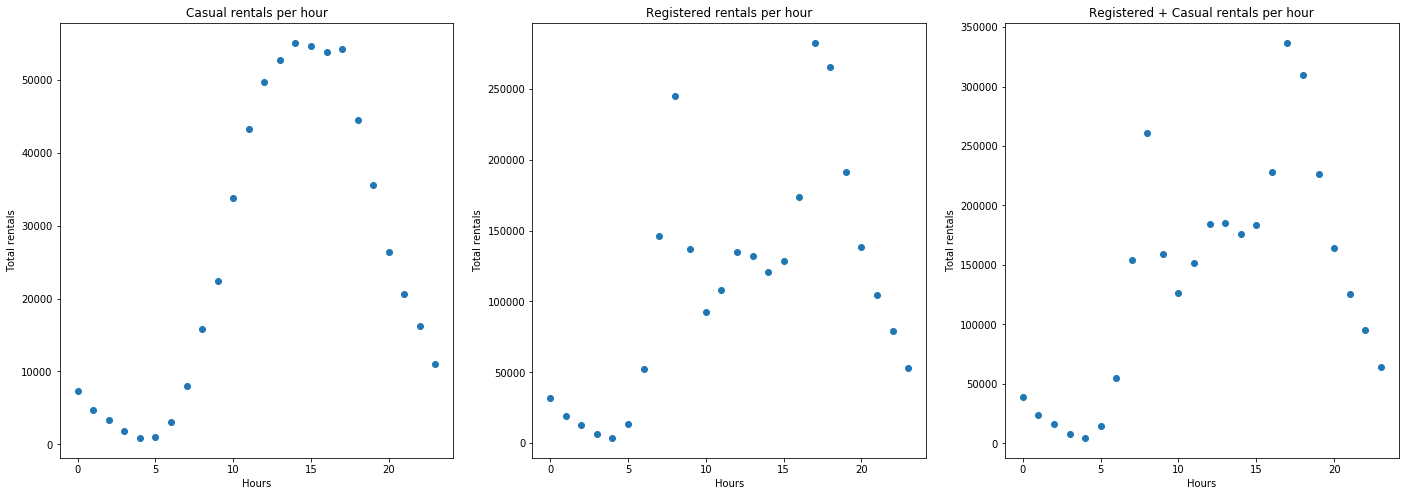

In [5]:
hour_casual = bikes_df.groupby('hour')['casual'].sum()
hour_registered = bikes_df.groupby('hour')['registered'].sum()

fig, ax = plt.subplots(1,3,figsize = (24,8))
ax[0].scatter(hour_casual.index, hour_casual)
ax[0].set_title('Casual rentals per hour')
ax[0].set_ylabel('Total rentals')
ax[0].set_xlabel('Hours')
ax[1].scatter(hour_registered.index, hour_registered)
ax[1].set_title('Registered rentals per hour')
ax[1].set_ylabel('Total rentals')
ax[1].set_xlabel('Hours')
ax[2].scatter(hour_registered.index, hour_registered + hour_casual)
ax[2].set_title('Registered + Casual rentals per hour')
ax[2].set_ylabel('Total rentals')
ax[2].set_xlabel('Hours')
plt.show()

<HR>
Your answer here<HR>

It seem to have a polynomial relation when the hour varies. In the casual plot, it's really amazing the curve, a second or third degree. In the registered, it's not so clear the polynomial degree. 

#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

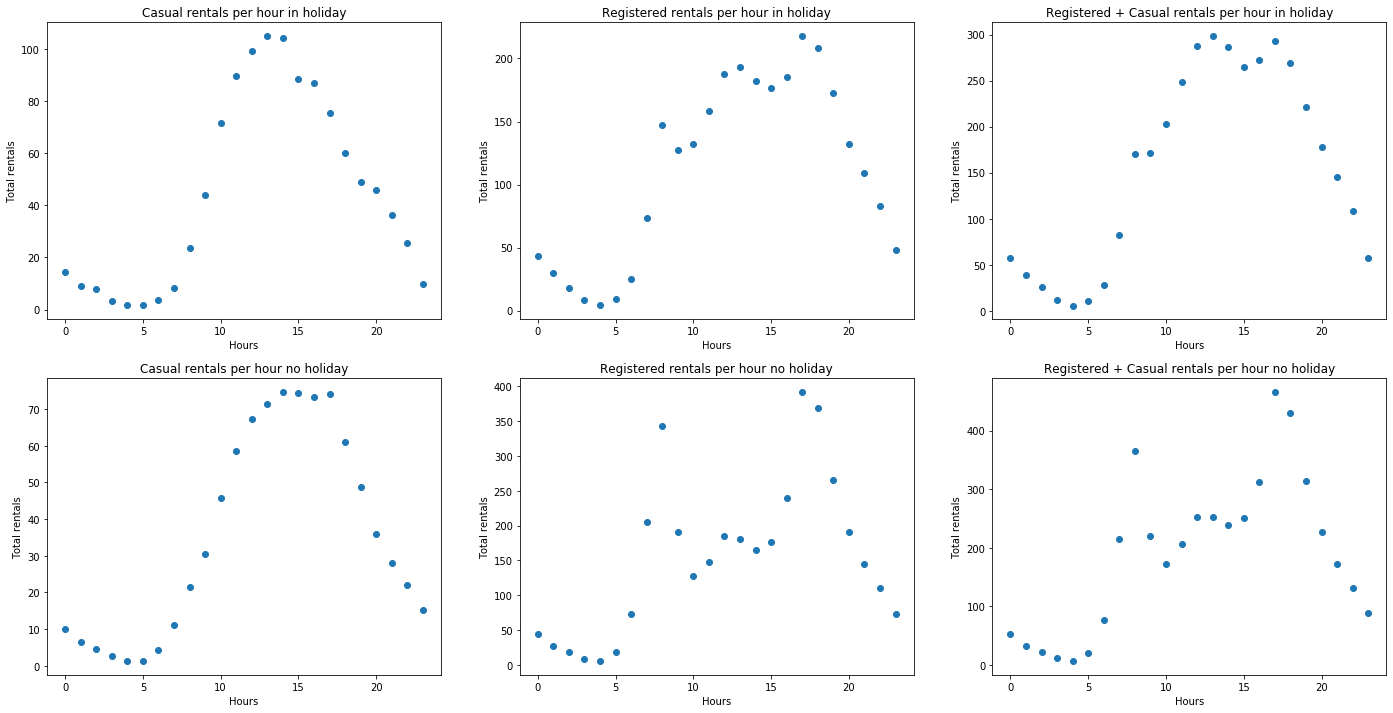

In [6]:
hour_casual_hol = bikes_df[bikes_df.holiday == True].groupby('hour')['casual'].mean()
hour_casual_wd = bikes_df[bikes_df.holiday == False].groupby('hour')['casual'].mean()
hour_registered_hol = bikes_df[bikes_df.holiday == True].groupby('hour')['registered'].mean()
hour_registered_wd = bikes_df[bikes_df.holiday == False].groupby('hour')['registered'].mean()

fig, ax = plt.subplots(2,3,figsize = (24,12))
ax[0][0].scatter(hour_casual_hol.index, hour_casual_hol)
ax[0][0].set_title('Casual rentals per hour in holiday')
ax[0][0].set_ylabel('Total rentals')
ax[0][0].set_xlabel('Hours')
ax[0][1].scatter(hour_registered_hol.index, hour_registered_hol)
ax[0][1].set_title('Registered rentals per hour in holiday')
ax[0][1].set_ylabel('Total rentals')
ax[0][1].set_xlabel('Hours')
ax[0][2].scatter(hour_registered_hol.index, hour_registered_hol + hour_casual_hol)
ax[0][2].set_title('Registered + Casual rentals per hour in holiday')
ax[0][2].set_ylabel('Total rentals')
ax[0][2].set_xlabel('Hours')

ax[1][0].scatter(hour_casual_wd.index, hour_casual_wd)
ax[1][0].set_title('Casual rentals per hour no holiday')
ax[1][0].set_ylabel('Total rentals')
ax[1][0].set_xlabel('Hours')
ax[1][1].scatter(hour_registered_wd.index, hour_registered_wd)
ax[1][1].set_title('Registered rentals per hour no holiday')
ax[1][1].set_ylabel('Total rentals')
ax[1][1].set_xlabel('Hours')
ax[1][2].scatter(hour_registered_wd.index, hour_registered_wd + hour_casual_wd)
ax[1][2].set_title('Registered + Casual rentals per hour no holiday')
ax[1][2].set_ylabel('Total rentals')
ax[1][2].set_xlabel('Hours')

plt.show()

<HR>
Your answer here<BR>
<HR>
    
I plotted the mean because it puts in the same unity. If we considerer the sum, the difference is much bigger. We perceive that the casual rentals do not chance much, but the registered change a lot, maily in the working hours (9h - 16h)

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

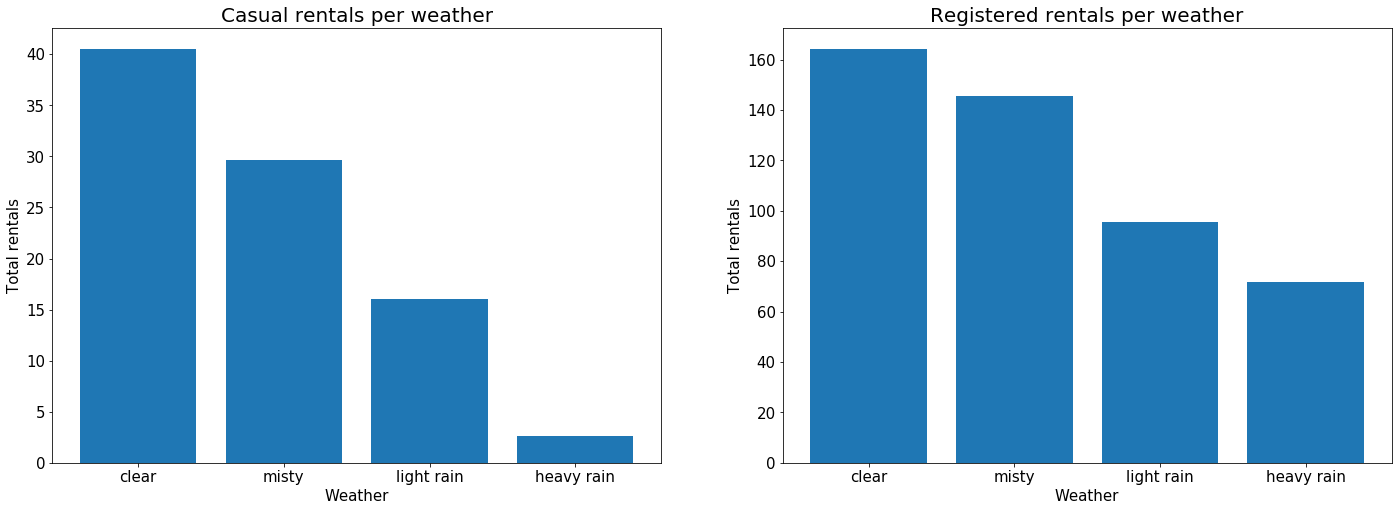

In [7]:
weather_casual = bikes_df.groupby('weather')['casual'].mean()
weather_registered = bikes_df.groupby('weather')['registered'].mean()

fig, ax = plt.subplots(1,2,figsize = (24,8))
weather = ['clear','misty','light rain','heavy rain']
ax[0].bar(weather, weather_casual)
ax[0].set_title('Casual rentals per weather', fontsize = 20)
ax[0].set_ylabel('Total rentals', fontsize = 15)
ax[0].set_xlabel('Weather', fontsize = 15)
ax[0].tick_params(labelsize = 15)
ax[1].bar(weather, weather_registered)
ax[1].set_title('Registered rentals per weather', fontsize = 20)
ax[1].set_ylabel('Total rentals', fontsize = 15)
ax[1].set_xlabel('Weather', fontsize = 15)
ax[1].tick_params(labelsize = 15)
plt.show()

<HR>
Your answer here
<HR>

I observe the obvious: As clear the weather is, more the rentals, in registered and in casual.

<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>

#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [8]:
first_func = lambda x: x.iloc[0]
bikes_by_day = bikes_df.groupby('dteday').agg({'weekday': first_func, 
                                               'weather': np.max, 
                                               'season': first_func, 
                                               'temp': np.mean,
                                               'atemp': np.mean, 
                                               'hum': np.mean,
                                               'windspeed': np.mean,
                                               'casual': np.sum,
                                               'registered': np.sum,
                                               'counts': first_func})

#### 2.2 How does season affect the number of bike ...

Correlation between the variables


casual        0.210399
registered    0.411623
Name: season, dtype: float64

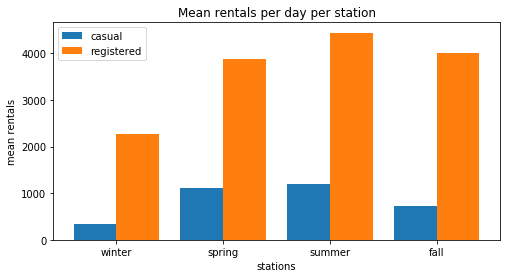

In [9]:
print('Correlation between the variables')
display(bikes_by_day.corr()[['casual','registered']].loc['season'])

season = bikes_by_day.groupby('season')[['casual','registered']].mean()

fig, ax = plt.subplots(figsize = (8,4))
labels = ['winter', 'spring', 'summer', 'fall']
x = np.array([1,2,3,4])
width = 0.4
ax.bar(x - width/2 , height = season['casual'], width = width, label = 'casual')
ax.bar(x + width/2, height = season['registered'], width = width, label = 'registered')
ax.set_title('Mean rentals per day per station')
ax.set_ylabel('mean rentals')
ax.set_xlabel('stations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

<HR>
Your answer here
<HR>
    
Observe there is a positive correlation between those variables, although it doesn't tell much about all. The bar plot says to us that the summer, spring and fall have more rentals comparing to winter. Comparing fall with spring we have two cases: in casual rentals, more in spring, less in fall. In registered rentals, more in fall, less in spring (considering the mean value). But, they are quite similar. 

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

In [10]:
weekday = bikes_by_day.groupby('weekday')[['casual','registered']].sum()
weekday['total'] = weekday['casual'] + weekday['registered']
weekday['casual'] = 100*weekday['casual']/weekday['total']
weekday['registered'] = 100*weekday['registered']/weekday['total']
display(weekday[['casual', 'registered']])

,casual,registered
weekday,,
0,31.646949,68.353051
1,15.539744,84.460256
2,12.330397,87.669603
3,12.116952,87.883048
4,12.661853,87.338147
5,16.039279,83.960721
6,32.199612,67.800388


<HR>
Your answer here
<HR>
    
A pattern is the weekend. In the weekend (0 and 6), the proportion is different from the week. Maybe it occurs, because mode people like to use bikes in the weekend, but do not want to register, only for a tour, playing, etc.

#### 2.4 How is the distribution of total number of bike rentals different ...

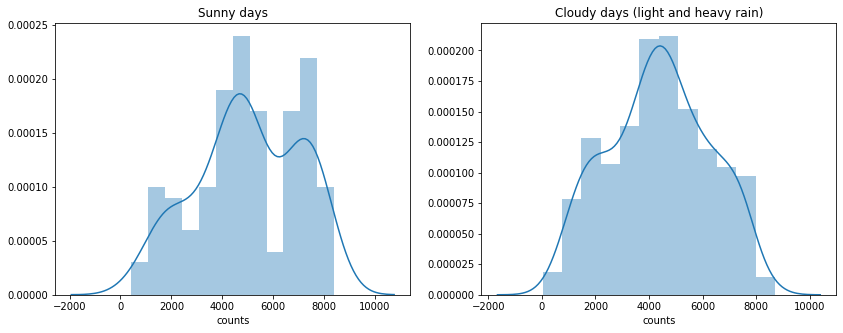

In [11]:
sunny_days = bikes_by_day[bikes_by_day['weather'] == 1]['counts']
cloudy_days = bikes_by_day[bikes_by_day['weather'] != 1]['counts']
fig, ax = plt.subplots(1,2, figsize = (14,5))
sns.distplot(sunny_days, ax = ax[0], bins = 12)
ax[0].set_title('Sunny days')
sns.distplot(cloudy_days, ax = ax[1], bins = 12)
ax[1].set_title('Cloudy days (light and heavy rain)')
plt.show()

<HR>
Your answer here
<HR>
    
The distributions aren't much differents. The main difference is that there is a second peak at 8000 (approx.). The cloudy days are more dispersive too. 

#### 2.5 Visualize how the total number of rides per day ...

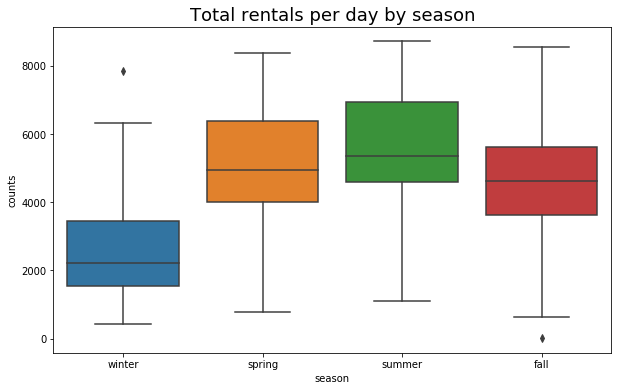

In [12]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.boxplot(x = 'season', y = 'counts', data = bikes_by_day[['season','counts']])
ax.set_title('Total rentals per day by season', fontsize = 18)
ax.set_xticklabels(['winter','spring','summer','fall'])
plt.show()

<HR>
Your answer here
<HR>
    
Yes, there are outliers in the winter and in the fall. he “whiskers” extend to points that lie within 1.5 IQRs of the lower and upper quartile. Let's investigate it!

In [13]:
Q1_winter = bikes_by_day[bikes_by_day.season == 1]['counts'].quantile(0.25)
Q1_fall = bikes_by_day[bikes_by_day.season == 4]['counts'].quantile(0.25)
Q3_winter = bikes_by_day[bikes_by_day.season == 1]['counts'].quantile(0.75)
Q3_fall = bikes_by_day[bikes_by_day.season == 4]['counts'].quantile(0.75)
IQR_winter = Q3_winter - Q1_winter
IQR_fall = Q3_fall - Q1_fall
print("Outlier in the fall: In this day, the hurricane Sandy passed throw Washington D.C.")
print("Reference: https://www.theguardian.com/world/2012/oct/29/washington-dc-shutdown-hurricane-sandy")
display(bikes_by_day[(bikes_by_day['counts'] < (Q1_fall - 1.5 * IQR_fall)) & (bikes_by_day.season == 4)])
print("Outlier in the winter: In this day it was St. Patrick Day. Even President Obama enjoyed it!")
print("Reference: https://wtop.com/news/2012/03/obama-marks-st-patricks-day-at-the-dubliner/")
display(bikes_by_day[(bikes_by_day['counts'] > (Q3_winter + 1.5 * IQR_winter)) & (bikes_by_day.season == 1)])

Outlier in the fall: In this day, the hurricane Sandy passed throw Washington D.C.
Reference: https://www.theguardian.com/world/2012/oct/29/washington-dc-shutdown-hurricane-sandy


,weekday,weather,season,temp,atemp,hum,windspeed,casual,registered,counts
dteday,,,,,,,,,,
2012-10-29,1,3,4,0.44,0.4394,0.88,0.3582,2,20,22


Outlier in the winter: In this day it was St. Patrick Day. Even President Obama enjoyed it!
Reference: https://wtop.com/news/2012/03/obama-marks-st-patricks-day-at-the-dubliner/


,weekday,weather,season,temp,atemp,hum,windspeed,casual,registered,counts
dteday,,,,,,,,,,
2012-03-17,6,2,1,0.514167,0.505046,0.755833,0.110704,3155,4681,7836


<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

,weekday,season,month,weather,temp,atemp,hum,windspeed,casual,registered,counts
weekday,1.000000,-0.002335,0.010400,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.064204
season,-0.002335,1.000000,0.830386,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.408077
month,0.010400,0.830386,1.000000,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.277704
weather,0.003311,-0.014524,0.005400,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.230464
temp,-0.001795,0.312025,0.201691,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.592402
atemp,-0.008821,0.319380,0.208096,-0.105563,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.594557
hum,-0.037158,0.150625,0.164411,0.418130,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933,-0.067356
windspeed,0.011502,-0.149773,-0.135386,0.026226,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321,-0.145990
casual,0.032721,0.120206,0.068457,-0.152628,0.459616,0.454080,-0.347028,0.090287,1.000000,0.506618,0.386582
registered,0.021578,0.174226,0.122273,-0.120966,0.335361,0.332559,-0.273933,0.082321,0.506618,1.000000,0.398120


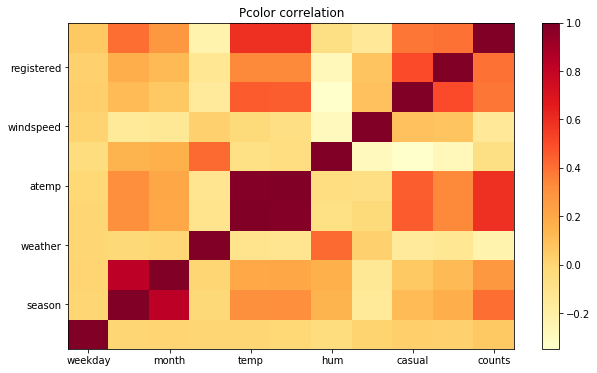

In [14]:
variables = ['weekday','season','month','weather','temp','atemp','hum','windspeed','casual','registered','counts']
display(bikes_df[variables].corr())

fig, ax = plt.subplots(figsize = (10, 6))
c = ax.pcolor(bikes_df[variables].corr(), cmap='YlOrRd')
ax.set_title('Pcolor correlation')
ax.set_xticks([0.5,2.5,4.5,6.5,8.5, 10.5])
ax.set_xticklabels([v for i,v in enumerate(variables) if i%2 == 0])
ax.set_yticks([1.5,3.5,5.5,7.5,9.5])
ax.set_yticklabels([v for i,v in enumerate(variables) if i%2 == 1])
fig.colorbar(c, ax=ax)

# The pairplot was inconclusive...
# sns.pairplot(bikes_df[variables], y_vars = variables[0:4], x_vars = variables[4:], kind = 'scatter')
plt.show()

<HR>
Your answer here
<HR>
    
Observe that there is a clear correlation between temp and atemp. This makes sense, because it is releated to the same thing. Season and month have a big relation too. Of course, if we know the month, we know the season, one is function of other. Is not exact linear, because the winter (1) starts in December (12). Casual and registered rentals present big correlation too! This is interesting because it says that there is increases in the will to use bike (casually or not!). With count it's interesing that it loses the correlation. We see a moderate positive correlation between temp and atemp with counts (casual and regiistered too). Thats is interesting! Hot days, more people rent bikes. After, there is relation between huminity and weather. Rainy days occur with more damp days. We have a moderate correlation between season and counts too. Other have less than 0.3 of correlation. 

#### 3.2 Convert the categorical attributes  ....

In [15]:
months = bikes_df.month
bikes_df = pd.get_dummies(bikes_df, columns = ['season','weekday','weather','month'], drop_first = True)

#### 3.3 Split the initial bikes_df dataset...

In [16]:
train_df, test_df = train_test_split(bikes_df, stratify = months, test_size = 0.2)

<HR>
Your answer here
<HR>
    
I chose this algorithm because it's simple and well implemented in pandas module. 

#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [17]:
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')
BSS_train = BSS_train.drop(labels = ['dteday','casual','registered', 'Unnamed: 0'], axis = 1)
BSS_test = BSS_test.drop(labels = ['dteday','casual','registered', 'Unnamed: 0'], axis = 1)

#### 3.5 Calculate the **Pearson correlation** ....

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
hour,1.000000,0.005028,-0.010900,0.002024,0.140745,0.136311,-0.274146,0.139770,0.394167,-0.003675,...,-0.008559,0.002398,0.002814,0.000877,-0.000289,-0.000661,-0.007787,-0.050553,0.020257,-0.005253
holiday,0.005028,1.000000,0.011641,-0.253523,-0.026372,-0.030072,-0.010085,-0.000291,-0.028252,-0.026538,...,0.003484,0.288895,-0.045881,-0.046017,-0.023697,-0.027916,-0.071661,0.007805,-0.021242,-0.002083
year,-0.010900,0.011641,1.000000,-0.000840,0.038813,0.037635,-0.086934,-0.008300,0.243886,-0.003334,...,-0.000215,0.003327,-0.003703,0.001554,0.003746,-0.000422,-0.010093,0.013921,-0.038232,-0.000110
workingday,0.002024,-0.253523,-0.000840,1.000000,0.056547,0.055666,0.020164,-0.009580,0.029534,0.022044,...,-0.019465,0.147598,0.268793,0.272720,0.260472,0.263344,-0.602438,0.022523,0.034080,-0.004647
temp,0.140745,-0.026372,0.038813,0.056547,1.000000,0.987408,-0.071756,-0.018421,0.406155,0.142863,...,-0.276243,-0.000895,0.025038,0.016462,0.021504,0.000682,-0.036657,-0.071525,-0.062334,-0.019716
atemp,0.136311,-0.030072,0.037635,0.055666,0.987408,1.000000,-0.053984,-0.058252,0.401119,0.151023,...,-0.267651,0.004153,0.027500,0.014942,0.021189,-0.007918,-0.037245,-0.068782,-0.068844,-0.021537
hum,-0.274146,-0.010085,-0.086934,0.020164,-0.071756,-0.053984,1.000000,-0.286629,-0.328232,0.002175,...,0.063829,0.013808,0.032100,0.042039,-0.042152,-0.024094,-0.019439,0.221191,0.309075,0.016521
windspeed,0.139770,-0.000291,-0.008300,-0.009580,-0.018421,-0.058252,-0.286629,1.000000,0.093981,0.063466,...,-0.033493,-0.002639,0.008295,-0.009246,0.005465,-0.014696,0.018772,-0.052600,0.077704,0.006998
counts,0.394167,-0.028252,0.243886,0.029534,0.406155,0.401119,-0.328232,0.093981,1.000000,0.058418,...,-0.080273,-0.009796,-0.004783,0.006535,0.018731,0.015080,0.000878,-0.050171,-0.130511,-0.010548
spring,-0.003675,-0.026538,-0.003334,0.022044,0.142863,0.151023,0.002175,0.063466,0.058418,1.000000,...,-0.177812,0.009869,0.000596,0.007562,-0.003677,0.002232,-0.006187,-0.007358,0.018801,-0.006984


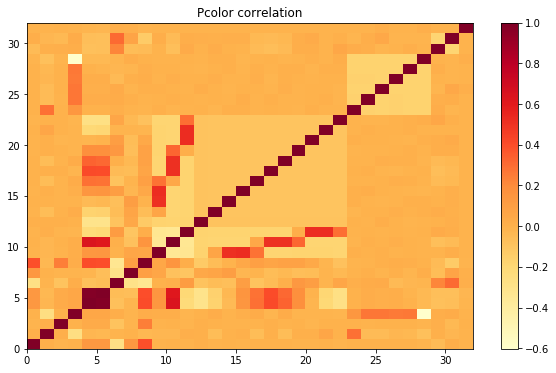

In [18]:
pearson = BSS_train.corr() 
display(pearson.head(10))

fig, ax = plt.subplots(figsize = (10, 6))
c = ax.pcolor(BSS_train.corr(), cmap='YlOrRd')
ax.set_title('Pcolor correlation')
fig.colorbar(c, ax=ax)
plt.show()

For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

In [19]:
print('''The predictors {} have a positive correlation with the number of bike rentals'''.format(
        list(pearson[pearson.counts > 0].index)))
print('-'*100)
print('These pars of predicts have collinearity > 0.7: {}'.format(
        list(pearson[pearson > 0.7].dropna(thresh = 2).index)))

The predictors ['hour', 'year', 'workingday', 'temp', 'atemp', 'windspeed', 'counts', 'spring', 'summer', 'fall', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Wed', 'Thu', 'Fri', 'Sat'] have a positive correlation with the number of bike rentals
----------------------------------------------------------------------------------------------------
These pars of predicts have collinearity > 0.7: ['temp', 'atemp']


<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [20]:
x_train  = sm.add_constant(BSS_train.drop('counts', axis = 1))
x_test   = sm.add_constant(BSS_test.drop('counts', axis = 1))
y_train  = BSS_train.counts
y_test   = BSS_test.counts

full_model = OLS(y_train, x_train).fit()

print("R^2 in the train set: {}".format(r2_score(y_train, full_model.predict(x_train))))
print("R^2 in the test set: {}".format(r2_score(y_test, full_model.predict(x_test))))

R^2 in the train set: 0.4065387827969087
R^2 in the test set: 0.4063855475710224


#### 4.2 Find out which of estimated coefficients ...

In [21]:
significant = list(full_model.pvalues[full_model.pvalues < 0.05].index)
full_model.params[significant]

const         -21.083012
hour            7.221382
holiday       -18.095798
year           76.351903
workingday     11.317765
temp          333.248241
hum          -205.495864
windspeed      22.516841
spring         43.154064
summer         29.542551
fall           68.595334
Apr           -41.524384
May           -33.292706
Jun           -65.803934
Jul           -93.480482
Aug           -59.208113
Nov           -25.873181
Sat            14.945929
Cloudy          6.786806
Snow          -28.285890
dtype: float64

<HR>
Your answer here<BR>
<HR>
    Above we see estimated parameters with small pvalue. We see some of the months, only one weekday, all the seasons. We've lost atemp (because of the big linearity with temp, I think). The neggative constant joins lot of dummy variables (winter, january, sunday, clear). The temp and hum are with big absolute values estimated. 

#### 4.3 Make a plot of residuals of the fitted ...

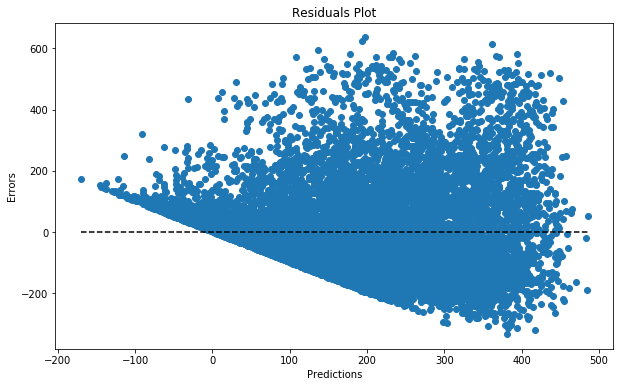

In [22]:
residuals = full_model.resid
predicted = full_model.predict(x_train)

fig = plt.figure(figsize = (10,6))
plt.scatter(predicted, residuals)
plt.hlines(0, min(predicted), max(predicted), linestyles='--')
plt.title('Residuals Plot')
plt.ylabel('Errors')
plt.xlabel('Predictions')

plt.show()

<HR>
Your answer here<BR>
<HR>

The variance increases as the prediction values increase. Other strange thing is this linear lower bound. It indicates that there is something our model does not captured 

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [23]:
def subset_selection(dataset: pd.DataFrame): 
    '''Select the best model using forward model selection and BIC to compare results.'''
    
    y_train = dataset.counts
    last_predictors = set(dataset.columns) - {'counts'}
    models = []
    models.append(OLS(y_train, sm.add_constant(dataset[[]])).fit())     # Add the mean model with 0 feeatures
    
    while len(last_predictors) > 0: 
        min_bic = np.inf
        
        for predictor in last_predictors:                                 # for each predictor, got the 
            variables = list(models[-1].params.index)[1:] + [predictor]   # min bic parameter
            x_train = sm.add_constant(dataset[variables])
            model = OLS(y_train, x_train).fit()
            if model.bic < min_bic:
                chosen_predictor = predictor
                min_bic = model.bic
                best_model = model
        models.append(best_model)
        last_predictors = last_predictors - {chosen_predictor}
    
    bics = [model.bic for model in models]
    index = bics.index(min(bics))
    
    return models[index]

#### 5.2 Do these methods eliminate ...

<HR>
Your answer here
<HR>
    
Yes, these methods eliminate. Suppose we have to select a new predictor. If the correlation is big, we increased the complexity of the model, so the BICs tend to increase, but, with high correlation, the models shouldn't get any betterw with one more variable. If the BIC values increase, this model will be better and two correlated variables should not be together. We can't say nothing about which one will be chosen. By my algorithm, I think ```atemp``` will be excluded from 3.5.  

#### 5.3 In each case, fit linear regression  ...

In [24]:
selected_model = subset_selection(BSS_train)
print("This was the used variables: ")
print(list(selected_model.params.index))
print('-'*100)

x_train  = sm.add_constant(BSS_train[list(selected_model.params.index)[1:]])
x_test   = sm.add_constant(BSS_test[list(selected_model.params.index)[1:]])
y_train  = BSS_train.counts
y_test   = BSS_test.counts

print("R^2 in the train set: {}".format(r2_score(y_train, selected_model.predict(x_train))))
print("R^2 in the test set: {}".format(r2_score(y_test, selected_model.predict(x_test))))

This was the used variables: 
['const', 'temp', 'hour', 'year', 'hum', 'fall', 'Jul', 'Snow', 'Aug', 'Jun', 'holiday', 'spring']
----------------------------------------------------------------------------------------------------
R^2 in the train set: 0.40382733393963366
R^2 in the test set: 0.4046908770536959


<HR>
Your answer here
<HR>
    
Actually the $R^2$ is worst when compared with the previous one. But, white similar, and we gain more simplicity on the model!

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [84]:
continuum = BSS_test.dtypes[(BSS_test.dtypes == 'float64') | (BSS_test.dtypes.index == 'hour')].index
variables_train = np.empty((len(BSS_train),1))
variables_test = np.empty((len(BSS_test),1))

transform = PolynomialFeatures(4, include_bias = False)
for variable in list(continuum):
    variables_train = np.concatenate((variables_train, transform.fit_transform(BSS_train[[variable]])), axis = 1)
    variables_test = np.concatenate((variables_test, transform.fit_transform(BSS_test[[variable]])), axis = 1)
variables_train = pd.DataFrame(variables_train[:, 1:], columns = ['hour1','hour2','hour3','hour4', 
                                                      'temp1','temp2','temp3','temp4',
                                                      'atemp1','atemp2','atemp3','atemp4', 
                                                      'hum1','hum2','hum3','hum4',
                                                      'windspeed1','windspeed2','windspeed3','windspeed4'], 
                         index = BSS_train.index)
variables_test = pd.DataFrame(variables_test[:, 1:], columns = ['hour1','hour2','hour3','hour4', 
                                                      'temp1','temp2','temp3','temp4',
                                                      'atemp1','atemp2','atemp3','atemp4', 
                                                      'hum1','hum2','hum3','hum4',
                                                      'windspeed1','windspeed2','windspeed3','windspeed4'], 
                         index = BSS_test.index)
BSS_train_pol = BSS_train.drop(['hour','temp','atemp','hum','windspeed'], axis = 1)
BSS_train_pol = BSS_train_pol.merge(variables_train, on = BSS_train_pol.index)
BSS_test_pol = BSS_test.drop(['hour','temp','atemp','hum','windspeed'], axis = 1)
BSS_test_pol = BSS_test_pol.merge(variables_test, on = BSS_test_pol.index)

In [92]:
x_train  = sm.add_constant(BSS_train_pol.drop('counts',axis =1))
x_test   = sm.add_constant(BSS_test_pol.drop('counts',axis =1))
y_train  = BSS_train_pol.counts
y_test   = BSS_test_pol.counts

model_polynomial = OLS(y_train, x_train).fit()
print("R^2 in the train set: {}".format(r2_score(y_train, model_polynomial.predict(x_train))))
print("R^2 in the test set: {}".format(r2_score(y_test, model_polynomial.predict(x_test))))

R^2 in the train set: 0.5553829075048409
R^2 in the test set: 0.48694472647005693


In [93]:
significant = list(model_polynomial.pvalues[model_polynomial.pvalues < 0.05].index)
model_polynomial.params[significant]

year           150.526032
workingday      13.132037
spring          40.127237
summer          39.421324
fall            73.538576
Feb             26.170661
Mar             49.537855
Apr             43.588910
May             51.556505
Jun             45.779037
Sept            74.281731
Oct             79.152251
Mon             -5.222733
Fri              8.175338
Sat             17.480924
Cloudy         -13.767612
Snow           -68.396573
hour1            6.800364
hour2            1.464153
hour4           -0.003695
temp3         5303.043915
temp4        -3481.456166
hum2          1560.904037
hum3         -2274.470836
hum4          1055.546158
windspeed3   -2509.044212
windspeed4    1898.061569
dtype: float64

<HR>
Your answer here
<HR>
The $R^2$ improved! 

#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

### Answers
#### 7
<HR>
Your report here
<HR>

